In [205]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter

In [206]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx") #./../../data/Preise.xlsx   - Pfad für Sandbox
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

In [207]:
df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

In [208]:
def read_regio_data(region, kind): 
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "transaction_id"]], on="transaction_id"))

df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

In [209]:
# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifische Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

In [210]:
df_reg_main

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,44,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,44,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,44,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,44,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,44,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335248,2022-10-31,Tablet Mini,1.0,4,0,1,0,NaN,247.07,NaN,...,44,247.07,988.28,550,2200,302.93,1211.72,9.1,D,store
335249,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,246.07,NaN,...,44,246.07,246.07,550,550,303.93,303.93,7.1,D,store
335250,2022-10-31,Tablet Mini,1.0,2,0,1,0,NaN,246.05,NaN,...,44,246.05,492.10,550,1100,303.95,607.90,5.5,D,store
335251,2022-10-31,Tablet Mini,1.0,2,0,1,0,NaN,246.05,NaN,...,44,246.05,492.10,550,1100,303.95,607.90,6.2,D,store


In [211]:
df_basic = df_reg_main[df_reg_main["product"] == "Tablet Basic"]

df_basic

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,44,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,44,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,44,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,44,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,44,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292429,2022-10-27,Tablet Basic,0.9,3,1,0,0,535.74,NaN,NaN,...,43,535.74,1607.22,499,1497,-36.74,-110.22,4.4,D,store
292430,2022-10-27,Tablet Basic,0.9,7,1,0,0,655.75,NaN,NaN,...,43,655.75,4590.25,499,3493,-156.75,-1097.25,2.9,D,store
292431,2022-10-29,Tablet Basic,1.0,1,1,0,0,537.91,NaN,NaN,...,43,537.91,537.91,499,499,-38.91,-38.91,4.2,D,store
292432,2022-10-29,Tablet Basic,1.0,1,1,0,0,537.93,NaN,NaN,...,43,537.93,537.93,499,499,-38.93,-38.93,4.9,D,store


In [212]:
stats_per_month = df_basic.groupby(pd.Grouper(key="date",freq="1M")).agg({"transaction_id": "count", "price": "mean", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "mean"})
stats_per_week = df_basic.groupby(pd.Grouper(key="date",freq="1W")).agg({"transaction_id": "count", "price": "mean", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "mean"})
stats_per_month

,transaction_id,price,cost_per_unit,profit_per_unit,revenue,amount
date,,,,,,
2021-11-30,10759,529.0,200.830756,328.169244,1496.874802,2.829631
2021-12-31,10417,529.0,222.049048,306.950952,1505.240376,2.845445
2022-01-31,9325,499.0,243.053416,255.946584,1386.444075,2.778445
2022-02-28,7920,499.0,263.356908,235.643092,1408.729924,2.823106
2022-03-31,7667,499.0,285.830811,213.169189,1427.945741,2.861615
2022-04-30,6642,499.0,307.756781,191.243219,1379.049082,2.763625
2022-05-31,6114,499.0,332.284848,166.715152,1418.811907,2.843310
2022-06-30,4856,499.0,354.196365,144.803635,1393.212932,2.792010
2022-07-31,4227,499.0,380.369250,118.630750,1387.921221,2.781405


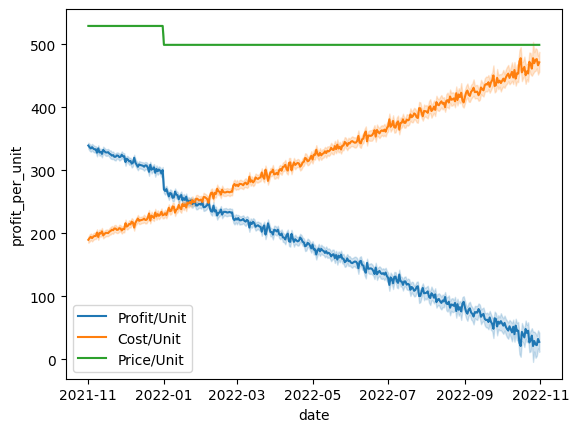

In [213]:
sns.lineplot(data=df_basic, x="date", y="profit_per_unit", label="Profit/Unit")
sns.lineplot(data=df_basic, x="date", y="cost_per_unit", label="Cost/Unit")
sns.lineplot(data=df_basic, x="date", y="price", label="Price/Unit")

plt.show()

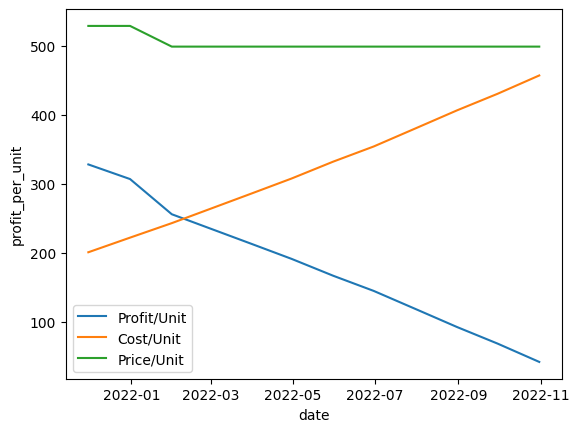

In [214]:
sns.lineplot(data=stats_per_month, x="date", y="profit_per_unit", label="Profit/Unit")
sns.lineplot(data=stats_per_month, x="date", y="cost_per_unit", label="Cost/Unit")
sns.lineplot(data=stats_per_month, x="date", y="price", label="Price/Unit")

plt.show()

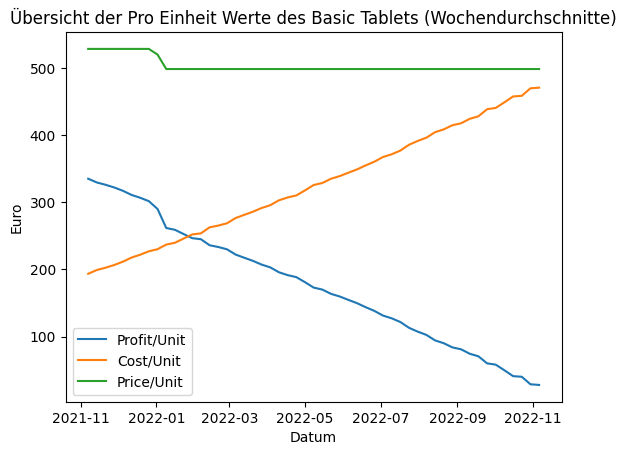

In [215]:
ax = sns.lineplot(data=stats_per_week, x="date", y="profit_per_unit", label="Profit/Unit")
sns.lineplot(data=stats_per_week, x="date", y="cost_per_unit", label="Cost/Unit")
sns.lineplot(data=stats_per_week, x="date", y="price", label="Price/Unit")

ax.set(title="Übersicht der Pro Einheit Werte des Basic Tablets (Wochendurchschnitte)", xlabel="Datum", ylabel="Euro")

plt.show()

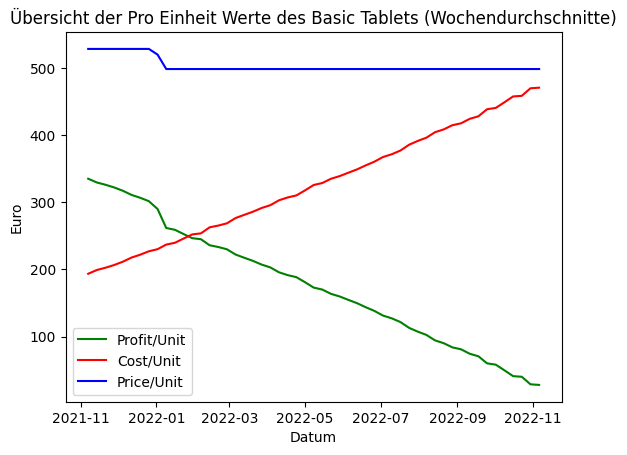

In [216]:
ax = sns.lineplot(data=stats_per_week, x="date", y="profit_per_unit", label="Profit/Unit", color="green")
sns.lineplot(data=stats_per_week, x="date", y="cost_per_unit", label="Cost/Unit", color="red")
sns.lineplot(data=stats_per_week, x="date", y="price", label="Price/Unit", color="blue")

ax.set(title="Übersicht der Pro Einheit Werte des Basic Tablets (Wochendurchschnitte)", xlabel="Datum", ylabel="Euro")

plt.show()

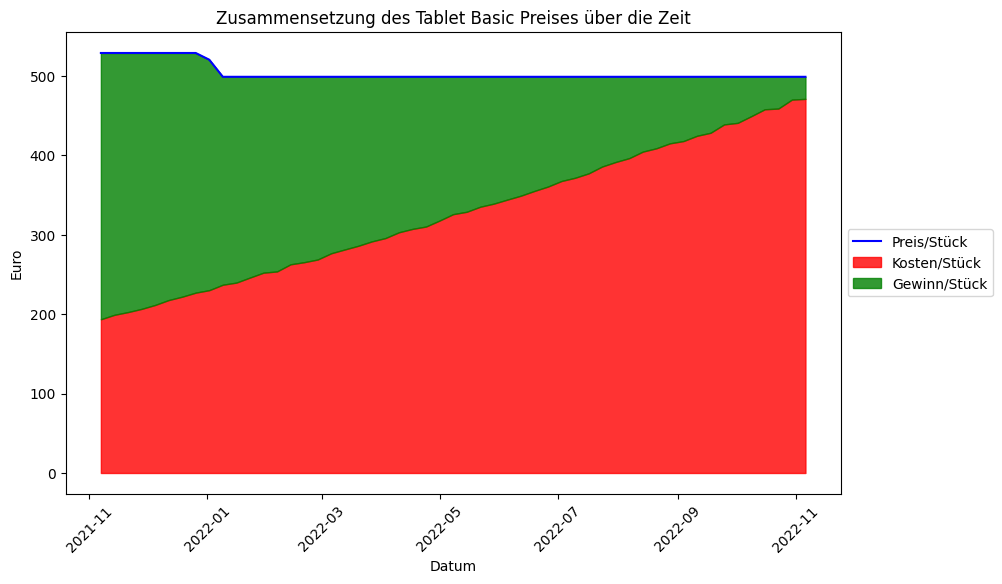

In [217]:
stats_per_week_res = stats_per_week.reset_index()

plt.figure(figsize=(10, 6))


ax = sns.lineplot(x='date', y='price', data=stats_per_week_res, label='Preis/Stück', color='blue')
plt.fill_between(stats_per_week_res['date'], 0, stats_per_week_res['cost_per_unit'], label='Kosten/Stück', color='red', alpha=0.8)
plt.fill_between(stats_per_week_res['date'], stats_per_week_res['cost_per_unit'], stats_per_week_res['cost_per_unit'] + stats_per_week_res['profit_per_unit'], label='Gewinn/Stück', color='green', alpha=0.8)



ax.set(title="Zusammensetzung des Tablet Basic Preises über die Zeit", xlabel="Datum", ylabel="Euro")
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



[Text(0.5, 1.0, 'Durschnittliche Basic Tablet Anzahl pro Transaktion (Wochendurchschnitte)'),
 Text(0.5, 0, 'Datum'),
 Text(0, 0.5, 'Stück')]

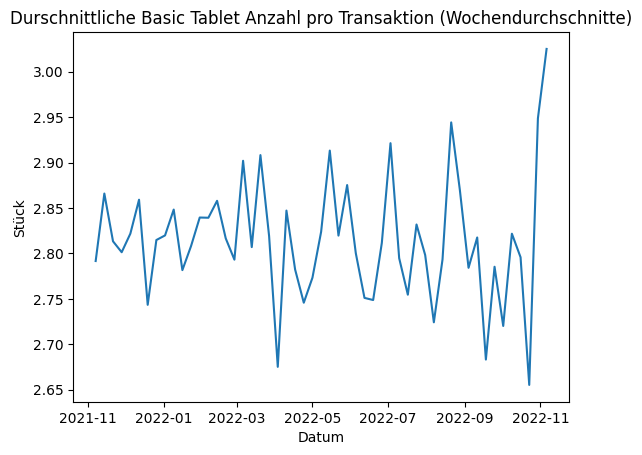

In [218]:
ax = sns.lineplot(data=stats_per_week, x="date", y="amount")
ax.set(title="Durschnittliche Basic Tablet Anzahl pro Transaktion (Wochendurchschnitte)", xlabel="Datum", ylabel="Stück")

[Text(0.5, 1.0, 'Anzahl der Transaktionen von Basic Tablets pro Woche'),
 Text(0.5, 0, 'Datum'),
 Text(0, 0.5, 'Transaktionen')]

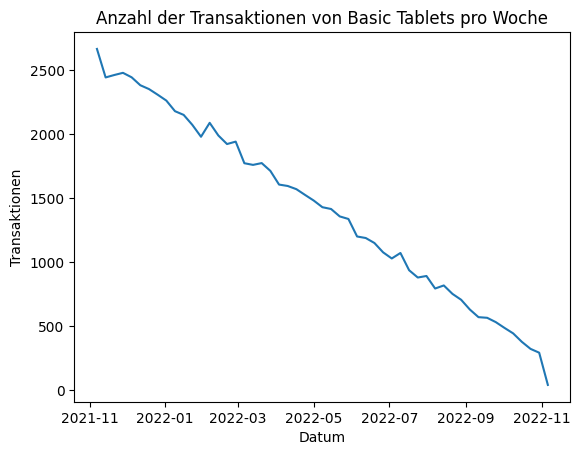

In [219]:
ax = sns.lineplot(data=stats_per_week, x="date", y="transaction_id")
ax.set(title="Anzahl der Transaktionen von Basic Tablets pro Woche", xlabel="Datum", ylabel="Transaktionen")

[Text(0.5, 1.0, 'Verkaufte Basic Tablets pro Woche'),
 Text(0.5, 0, 'Datum'),
 Text(0, 0.5, 'Stück')]

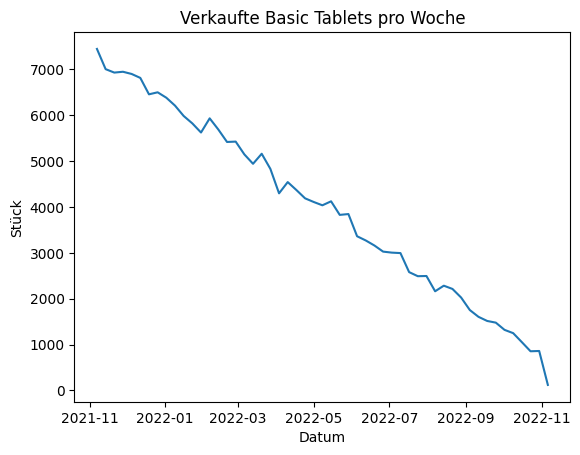

In [220]:
stats_per_week = df_basic.groupby(pd.Grouper(key="date",freq="1W")).agg({"transaction_id": "count", "price": "median", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "sum"})

ax = sns.lineplot(data=stats_per_week, x="date", y="amount")
ax.set(title="Verkaufte Basic Tablets pro Woche", xlabel="Datum", ylabel="Stück")

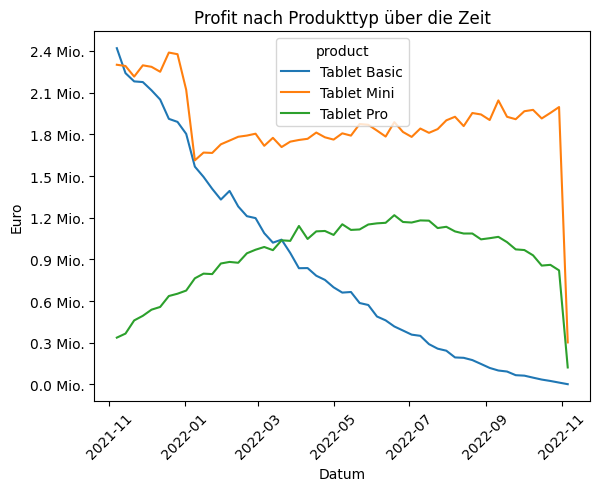

In [221]:
profit_by_type = df_reg_main.groupby(["product", pd.Grouper(key="date", freq="1W")]).agg({"profit": "sum"})

ax = sns.lineplot(data=profit_by_type, x="date", y="profit", hue="product")
ax.set(title='Profit nach Produkttyp über die Zeit', xlabel="Datum", ylabel="Euro")

def format_y_axis_millions(value, _):
    return f'{value / 1e6:.1f} Mio.'
ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis_millions))
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.xticks(rotation=45)

plt.show()

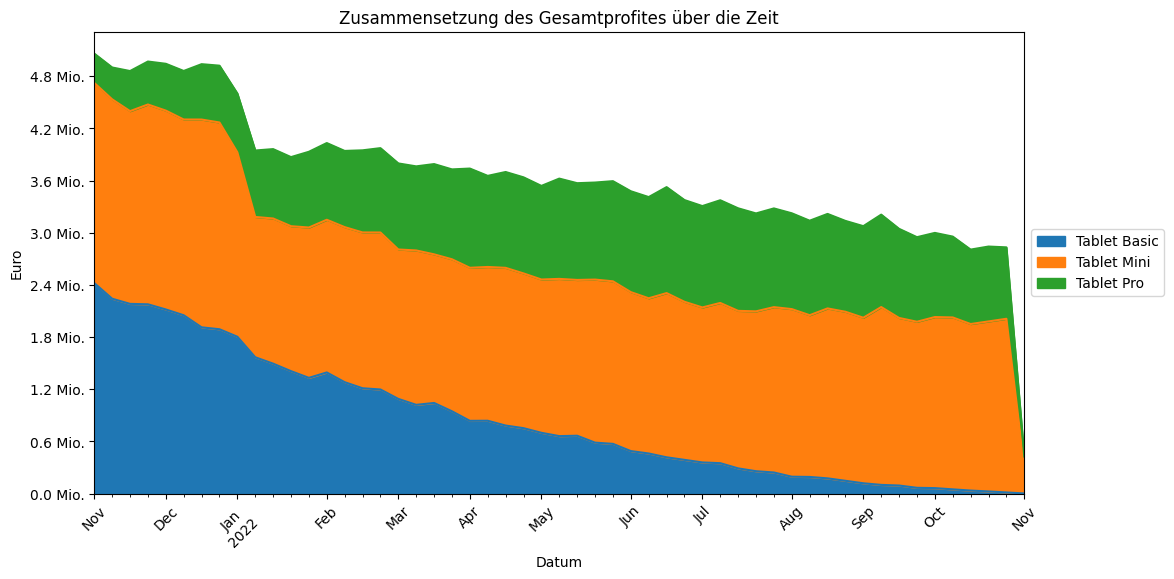

In [222]:
profit_by_type = df_reg_main.groupby(["product", pd.Grouper(key="date", freq="1W")]).agg({"profit": "sum"}).reset_index()
df_pivot = profit_by_type.pivot(index="date", columns="product", values="profit")

# Erstelle das gestapelte Flächendiagramm
ax = df_pivot.plot.area(stacked=True, figsize=(12, 6))

# Optional: Drehung der x-Achsenbeschriftungen für bessere Lesbarkeit
plt.xticks(rotation=45)

# Optional: Legende außerhalb des Plots positionieren
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Funktion zur Formatierung der y-Achsenticklabels
def format_y_axis(value, _):
    # Teile den Wert durch 1 Million und formatiere als Millionen mit einem Dezimalplatz
    return f'{value / 1e6:.1f} Mio.'

# Setze die benutzerdefinierte Formatierung auf der y-Achse
ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))

# Ändere die Einheiten auf der y-Achse direkt
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True)) 
ax.set(title='Zusammensetzung des Gesamtprofites über die Zeit', xlabel="Datum", ylabel="Euro")


# Diagramm anzeigen
plt.show()

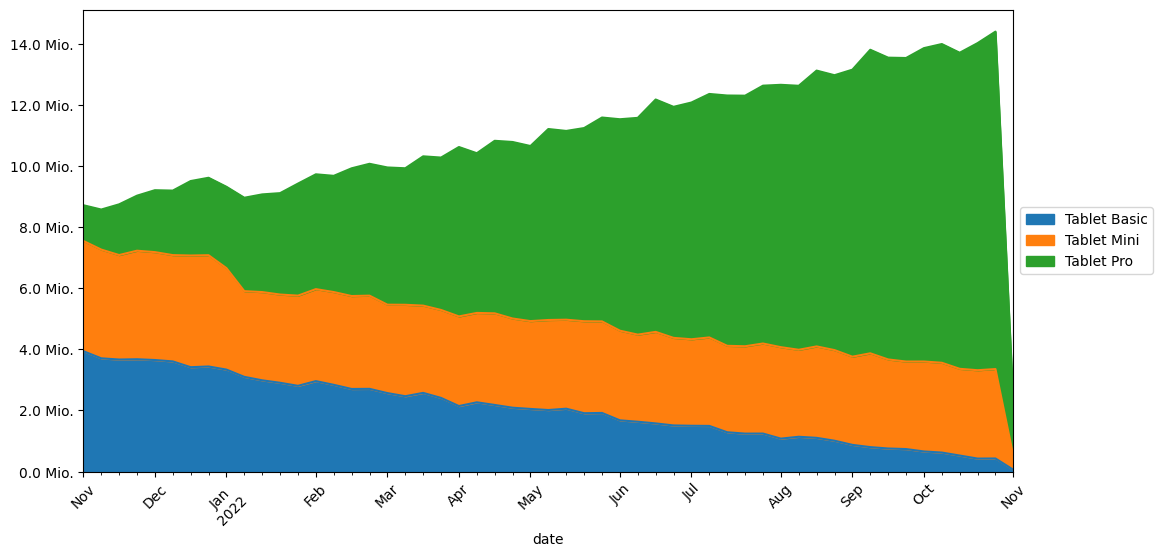

In [223]:
rev_by_type = df_reg_main.groupby(["product", pd.Grouper(key="date", freq="1W")]).agg({"revenue": "sum"}).reset_index()
df_pivot = rev_by_type.pivot(index="date", columns="product", values="revenue")

# Erstelle das gestapelte Flächendiagramm
ax = df_pivot.plot.area(stacked=True, figsize=(12, 6))

# Optional: Drehung der x-Achsenbeschriftungen für bessere Lesbarkeit
plt.xticks(rotation=45)

# Optional: Legende außerhalb des Plots positionieren
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Funktion zur Formatierung der y-Achsenticklabels
def format_y_axis(value, _):
    # Teile den Wert durch 1 Million und formatiere als Millionen mit einem Dezimalplatz
    return f'{value / 1e6:.1f} Mio.'

# Setze die benutzerdefinierte Formatierung auf der y-Achse
ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))

# Ändere die Einheiten auf der y-Achse direkt
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True)) 

# Diagramm anzeigen
plt.show()

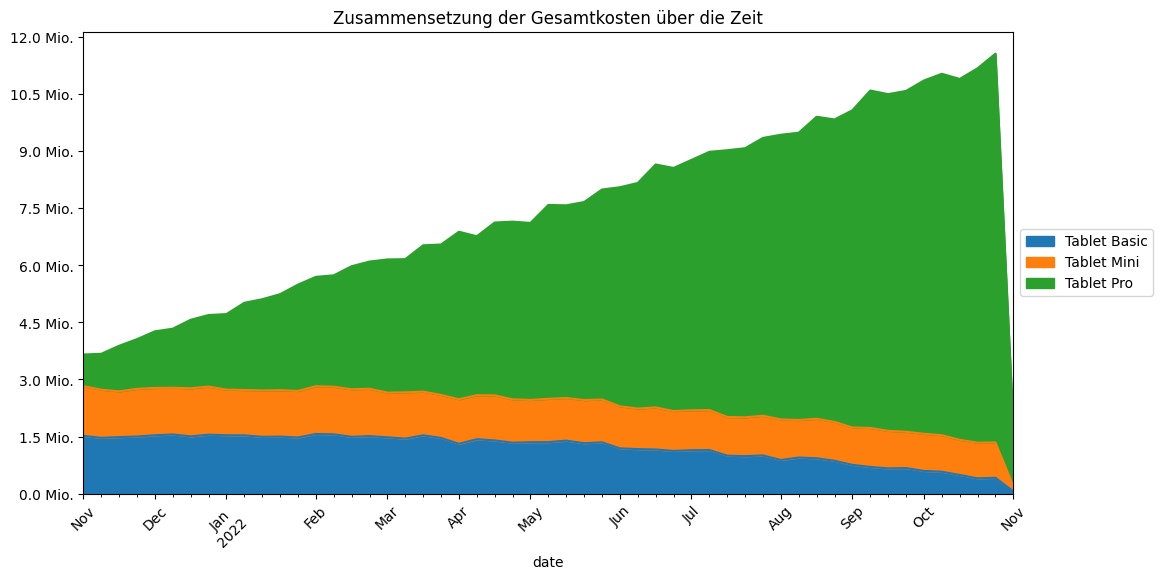

In [224]:
cost_by_type = df_reg_main.groupby(["product", pd.Grouper(key="date", freq="1W")]).agg({"cost": "sum"}).reset_index()
df_pivot = cost_by_type.pivot(index="date", columns="product", values="cost")

# Erstelle das gestapelte Flächendiagramm
ax = df_pivot.plot.area(stacked=True, figsize=(12, 6))

# Optional: Drehung der x-Achsenbeschriftungen für bessere Lesbarkeit
plt.xticks(rotation=45)

# Optional: Legende außerhalb des Plots positionieren
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Funktion zur Formatierung der y-Achsenticklabels
def format_y_axis(value, _):
    # Teile den Wert durch 1 Million und formatiere als Millionen mit einem Dezimalplatz
    return f'{value / 1e6:.1f} Mio.'

# Setze die benutzerdefinierte Formatierung auf der y-Achse
ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))

# Ändere die Einheiten auf der y-Achse direkt
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True)) 
ax.set_title('Zusammensetzung der Gesamtkosten über die Zeit')

# Diagramm anzeigen
plt.show()

<Axes: xlabel='date', ylabel='profit'>

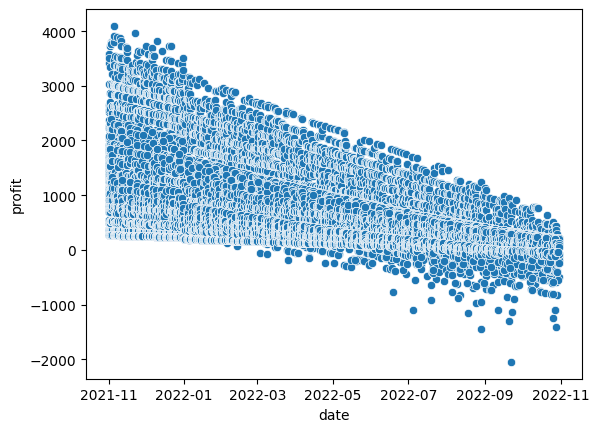

In [225]:
sns.scatterplot(data=df_basic, y="profit", x="date")

<Axes: xlabel='marketplace', ylabel='profit_per_unit'>

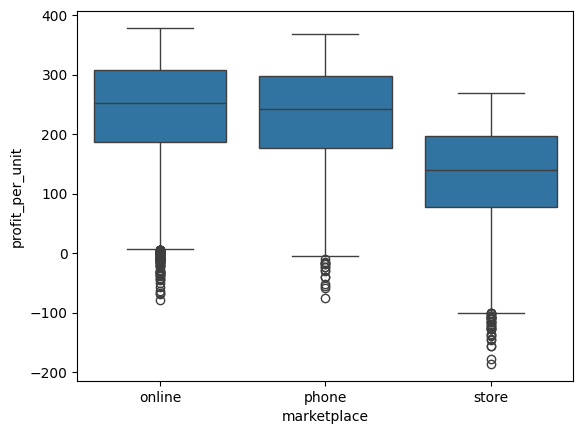

In [226]:
sns.boxplot(data=df_basic, y="profit_per_unit", x="marketplace")

In [227]:
df_basic_loss = df_basic[df_basic["profit"] <= 0]
df_basic_win = df_basic[df_basic["profit"] > 0]

In [228]:
df_basic_loss.sort_values(by="date")

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace
21786,2022-03-03,Tablet Basic,0.9,11,1,0,0,503.66,NaN,NaN,...,9,503.66,5540.26,499,5489,-4.66,-51.26,7.3,A,store
21821,2022-03-09,Tablet Basic,0.9,9,1,0,0,507.59,NaN,NaN,...,10,507.59,4568.31,499,4491,-8.59,-77.31,6.3,A,store
198125,2022-03-25,Tablet Basic,0.9,10,1,0,0,500.01,NaN,NaN,...,12,500.01,5000.10,499,4990,-1.01,-10.10,4.8,C,store
198137,2022-03-26,Tablet Basic,0.9,9,1,0,0,520.62,NaN,NaN,...,12,520.62,4685.58,499,4491,-21.62,-194.58,5.3,C,store
198138,2022-03-26,Tablet Basic,0.9,8,1,0,0,500.67,NaN,NaN,...,12,500.67,4005.36,499,3992,-1.67,-13.36,4.6,C,store
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169623,2022-10-31,Tablet Basic,1.0,6,1,0,0,539.15,NaN,NaN,...,44,539.15,3234.90,499,2994,-40.15,-240.90,2.6,C,phone
97036,2022-10-31,Tablet Basic,1.0,2,1,0,0,539.17,NaN,NaN,...,44,539.17,1078.34,499,998,-40.17,-80.34,3.1,B,store
151329,2022-10-31,Tablet Basic,0.9,8,1,0,0,529.15,NaN,NaN,...,44,529.15,4233.20,499,3992,-30.15,-241.20,3.7,C,online
97035,2022-10-31,Tablet Basic,1.0,3,1,0,0,539.16,NaN,NaN,...,44,539.16,1617.48,499,1497,-40.16,-120.48,3.9,B,store


[Text(0.5, 1.0, 'Verteilung der Transaktionen mit Verlust auf die Marktplätze'),
 Text(0.5, 0, 'Marktplatz'),
 Text(0, 0.5, 'Transaktionszahl')]

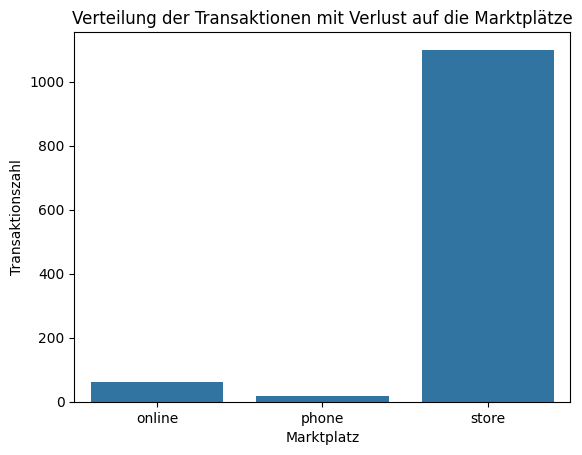

In [229]:
df_basic_loss_markets = df_basic_loss.groupby("marketplace").agg({"transaction_id": "count"})
ax = sns.barplot(data=df_basic_loss_markets, x="marketplace", y="transaction_id")
ax.set(title="Verteilung der Transaktionen mit Verlust auf die Marktplätze", xlabel="Marktplatz", ylabel="Transaktionszahl")

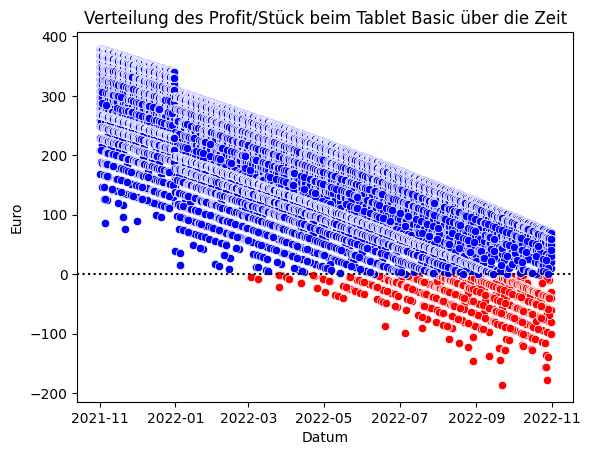

In [230]:
ax = sns.scatterplot(data=df_basic_loss, y="profit_per_unit", x="date", color="red")
ax = sns.scatterplot(data=df_basic_win, y="profit_per_unit", x="date", color="blue")
ax.set(title="Verteilung des Profit/Stück beim Tablet Basic über die Zeit", xlabel="Datum", ylabel="Euro")
ax.axhline(y=0, color="black", ls=":")

plt.show()

In [242]:
stats_basic_by_region = df_basic.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"cost_per_unit": "mean", "profit_per_unit": "mean", "transaction_id": "count", "amount": "sum"})
stats_basic_by_market = df_basic.groupby(["marketplace", pd.Grouper(key="date", freq="1W")]).agg({"cost_per_unit": "mean", "profit_per_unit": "mean", "transaction_id": "count", "amount": "sum"})

<Axes: xlabel='date', ylabel='cost_per_unit'>

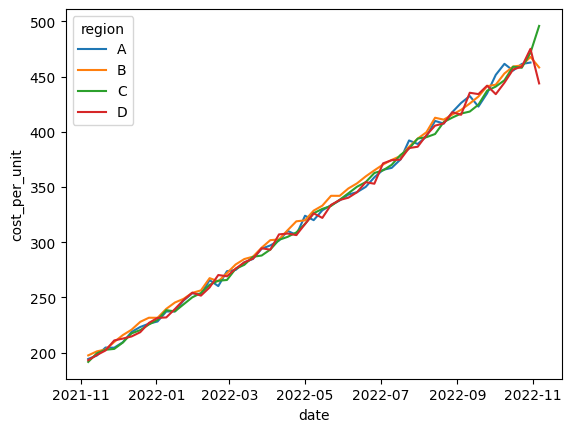

In [251]:
sns.lineplot(data=stats_basic_by_region, x="date", y="cost_per_unit", hue="region")

<Axes: xlabel='date', ylabel='cost_per_unit'>

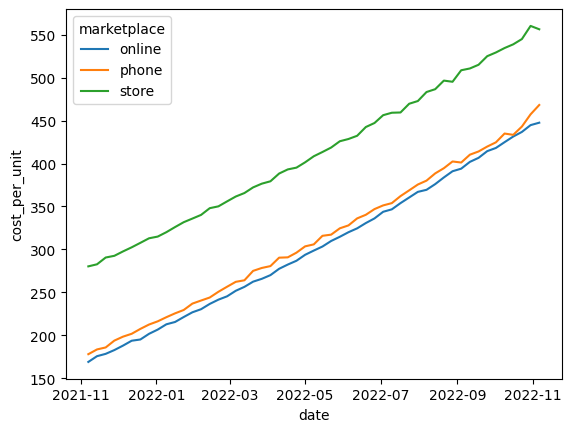

In [252]:
sns.lineplot(data=stats_basic_by_market, x="date", y="cost_per_unit", hue="marketplace")


<Axes: xlabel='date', ylabel='transaction_id'>

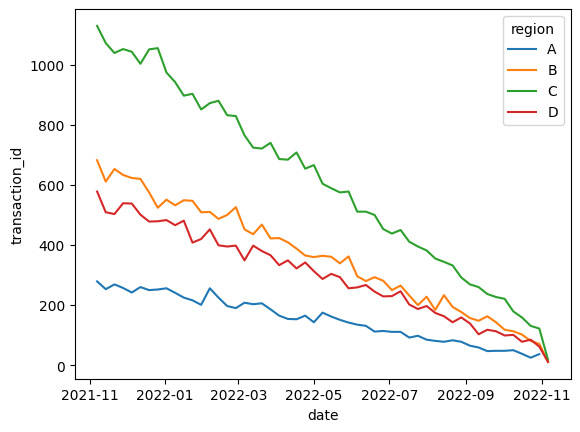

In [254]:
sns.lineplot(data=stats_basic_by_region, x="date", y="transaction_id", hue="region")

<Axes: xlabel='date', ylabel='transaction_id'>

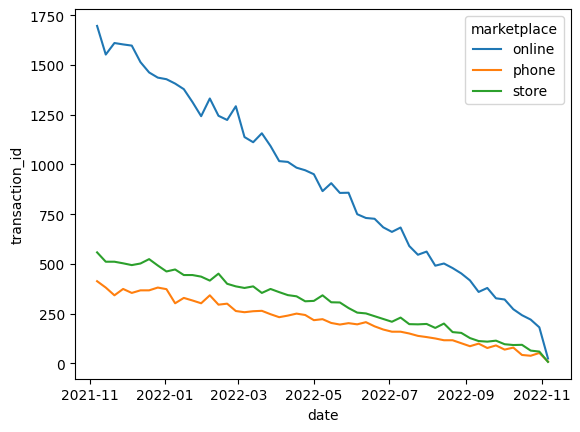

In [255]:
sns.lineplot(data=stats_basic_by_market, x="date", y="transaction_id", hue="marketplace")


<Axes: xlabel='date', ylabel='amount'>

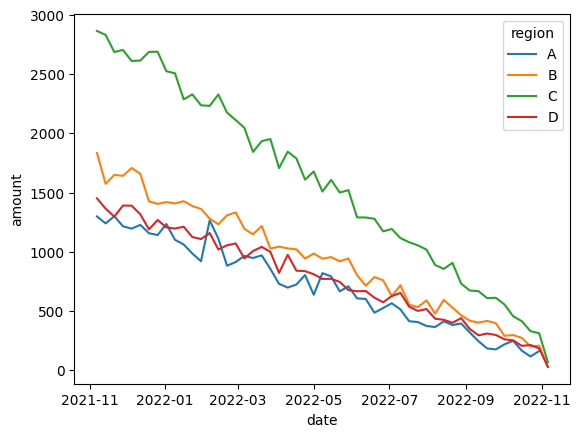

In [256]:
sns.lineplot(data=stats_basic_by_region, x="date", y="amount", hue="region")


<Axes: xlabel='date', ylabel='amount'>

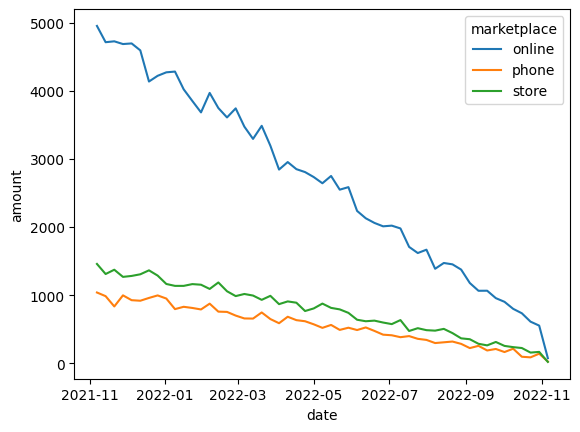

In [257]:
sns.lineplot(data=stats_basic_by_market, x="date", y="amount", hue="marketplace")


In [231]:
model_basic_profit = smf.ols("profit_per_unit ~ price + cost_per_unit", data=df_basic).fit()
model_basic_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        profit_per_unit   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.339e+30
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:02:04   Log-Likelihood:             1.7988e+06
No. Observations:               75253   AIC:                        -3.598e+06
Df Residuals:                   75250   BIC:                        -3.597e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.946e-11   1.72e-12     40.333      0.000    6.61e-11    7.28e-11
price             1.0000   3.23e-15   3.09e+14      0.000       1.000       1.000
cost_per_unit    -1.0000   5.02e-16  -1.99e+15      0.000      -1.000      -1.000
==============================================================================
Omnibus:                    31981.657   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15327.779
Skew:                           0.972   Prob(JB):                         0.00
Kurtosis:                       1.946   Cond. No.                     2.74e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [253]:
model_basic_cost = smf.ols("cost_per_unit ~ discount + amount + marketplace", data=df_basic).fit()
model_basic_cost.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          cost_per_unit   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     8740.
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:59:58   Log-Likelihood:            -4.1546e+05
No. Observations:               73001   AIC:                         8.309e+05
Df Residuals:                   72996   BIC:                         8.310e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              438.9478      6.339     69.242      0.000     426.523     451.373
marketplace[T.phone]    12.0474      0.820     14.696      0.000      10.441      13.654
marketplace[T.store]   113.4011      0.658    172.456      0.000     112.112     114.690
discount              -207.1378      6.317    -32.790      0.000    -219.519    -194.756
amount                   7.8849      0.155     50.766      0.000       7.580       8.189
==============================================================================
Omnibus:                     4734.555   Durbin-Watson:                   0.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5023.400
Skew:                           0.607   Prob(JB):                         0.00
Kurtosis:                       2.576   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [233]:
model_basic_profit = smf.ols("profit ~ amount + profit_per_unit", data=df_basic).fit()
model_basic_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                 2.092e+05
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:02:04   Log-Likelihood:            -4.9943e+05
No. Observations:               75253   AIC:                         9.989e+05
Df Residuals:                   75250   BIC:                         9.989e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -630.2858      2.137   -294.975      0.000    -634.474    -626.098
amount            205.0314      0.365    562.165      0.000     204.317     205.746
profit_per_unit     2.9250      0.007    406.929      0.000       2.911       2.939
==============================================================================
Omnibus:                    28552.037   Durbin-Watson:                   1.556
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           728494.357
Skew:                          -1.261   Prob(JB):                         0.00
Kurtosis:                      18.032   Cond. No.                         769.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [262]:
model_basic_profit = smf.ols("amount ~ customer_rating", data=df_basic).fit()
model_basic_profit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.047
Date:                Tue, 12 Dec 2023   Prob (F-statistic):              0.306
Time:                        22:05:40   Log-Likelihood:            -1.5385e+05
No. Observations:               75253   AIC:                         3.077e+05
Df Residuals:                   75251   BIC:                         3.077e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.7856      0.030     93.644      0.000       2.727       2.844
customer_rating     0.0053      0.005      1.023      0.306      -0.005       0.015
==============================================================================
Omnibus:                    21458.201   Durbin-Watson:                   1.481
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58802.815
Skew:                           1.529   Prob(JB):                         0.00
Kurtosis:                       6.067   Cond. No.                         25.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [274]:
stats_per_week = df_basic.groupby(pd.Grouper(key="date",freq="1W")).agg({"transaction_id": "count", "price": "mean", "cost_per_unit": "mean", "profit_per_unit": "mean", "revenue": "mean", "amount": "sum", "customer_rating": "mean", "profit": "sum"})


stats_per_week

,transaction_id,price,cost_per_unit,profit_per_unit,revenue,amount,customer_rating,profit
date,,,,,,,,
2021-11-07,2668,529.000000,193.623066,335.376934,1476.758621,7448,6.931072,2420574.66
2021-11-14,2445,529.000000,199.229501,329.770499,1516.033947,7007,6.832720,2240926.38
2021-11-21,2464,529.000000,202.651627,326.348373,1488.241883,6932,6.767045,2181573.41
2021-11-28,2481,529.000000,206.669895,322.330105,1481.882306,6950,6.662072,2176697.69
2021-12-05,2446,529.000000,211.618528,317.381472,1492.705642,6902,6.567825,2117436.82
2021-12-12,2384,529.000000,217.789790,311.210210,1512.442953,6816,6.470680,2050721.16
2021-12-19,2354,529.000000,222.051534,306.948466,1451.266780,6458,6.400085,1911909.71
2021-12-26,2310,529.000000,227.162494,301.837506,1488.986147,6502,6.284199,1889975.15
2022-01-02,2264,520.519435,230.283454,290.235981,1474.256184,6384,6.242712,1803680.61


In [260]:
model_basic_per_week = smf.ols("transaction_id ~ customer_rating", data=stats_per_week).fit()
model_basic_per_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         transaction_id   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     995.8
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           3.92e-35
Time:                        22:04:58   Log-Likelihood:                -342.53
No. Observations:                  53   AIC:                             689.1
Df Residuals:                      51   BIC:                             693.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2873.4435    137.773    -20.856      0.000   -3150.035   -2596.852
customer_rating   826.0514     26.177     31.556      0.000     773.499     878.604
==============================================================================
Omnibus:                        4.574   Durbin-Watson:                   0.178
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.451
Skew:                          -0.694   Prob(JB):                        0.108
Kurtosis:                       2.704   Cond. No.                         34.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [287]:
model_basic_per_week = smf.ols("amount ~ customer_rating + price", data=stats_per_week).fit()
model_basic_per_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     756.5
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           4.22e-38
Time:                        22:13:01   Log-Likelihood:                -386.44
No. Observations:                  53   AIC:                             778.9
Df Residuals:                      50   BIC:                             784.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        8759.9488   3159.516      2.773      0.008    2413.874    1.51e+04
customer_rating  2703.9098     91.886     29.427      0.000    2519.352    2888.468
price             -37.3382      6.951     -5.372      0.000     -51.299     -23.378
==============================================================================
Omnibus:                        2.766   Durbin-Watson:                   0.475
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.485
Skew:                          -0.525   Prob(JB):                        0.289
Kurtosis:                       2.845   Cond. No.                     3.17e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [285]:
model_basic_per_week = smf.ols("profit ~ amount + price + cost_per_unit", data=stats_per_week).fit()
model_basic_per_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     804.3
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.18e-41
Time:                        22:12:19   Log-Likelihood:                -685.77
No. Observations:                  53   AIC:                             1380.
Df Residuals:                      49   BIC:                             1387.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -9.4e+06   1.25e+06     -7.538      0.000   -1.19e+07   -6.89e+06
amount          242.2928     94.984      2.551      0.014      51.415     433.171
price          1.899e+04   1755.846     10.814      0.000    1.55e+04    2.25e+04
cost_per_unit  -897.6359   2249.322     -0.399      0.692   -5417.817    3622.545
==============================================================================
Omnibus:                        7.560   Durbin-Watson:                   0.236
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                6.988
Skew:                           0.875   Prob(JB):                       0.0304
Kurtosis:                       3.317   Cond. No.                     3.89e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [284]:
model_basic_per_week = smf.ols("profit ~ amount + profit_per_unit", data=stats_per_week).fit()
model_basic_per_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     591.2
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.60e-35
Time:                        22:12:16   Log-Likelihood:                -704.64
No. Observations:                  53   AIC:                             1415.
Df Residuals:                      50   BIC:                             1421.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -5.083e+05   4.61e+04    -11.027      0.000   -6.01e+05   -4.16e+05
amount           -225.1760     97.172     -2.317      0.025    -420.352     -30.000
profit_per_unit  1.272e+04   2148.766      5.921      0.000    8406.169     1.7e+04
==============================================================================
Omnibus:                        1.792   Durbin-Watson:                   0.331
Prob(Omnibus):                  0.408   Jarque-Bera (JB):                1.760
Skew:                           0.389   Prob(JB):                        0.415
Kurtosis:                       2.561   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""